# Предобработка

**Источник:** [https://scanpy-tutorials.readthedocs.io](https://scanpy-tutorials.readthedocs.io)

Данные, используемые в этих примерах состоят из 3 тыс PBMCs (мононуклеарные клетки периферической крови человека) от здорового донора и находятся в свободном доступе на сайте [10x Genomics](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.8


In [3]:
results_file = 'write/pbmc3k.h5ad'

In [4]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # директория с `.mtx` файлом
    var_names='gene_symbols',                # используем gene_symbols для имен переменных
    cache=True)                              # записываем файл кэша для более быстрого последующего чтения

... reading from cache file cache\data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Контроль качества данных

normalizing counts per cell
    finished (0:00:00)


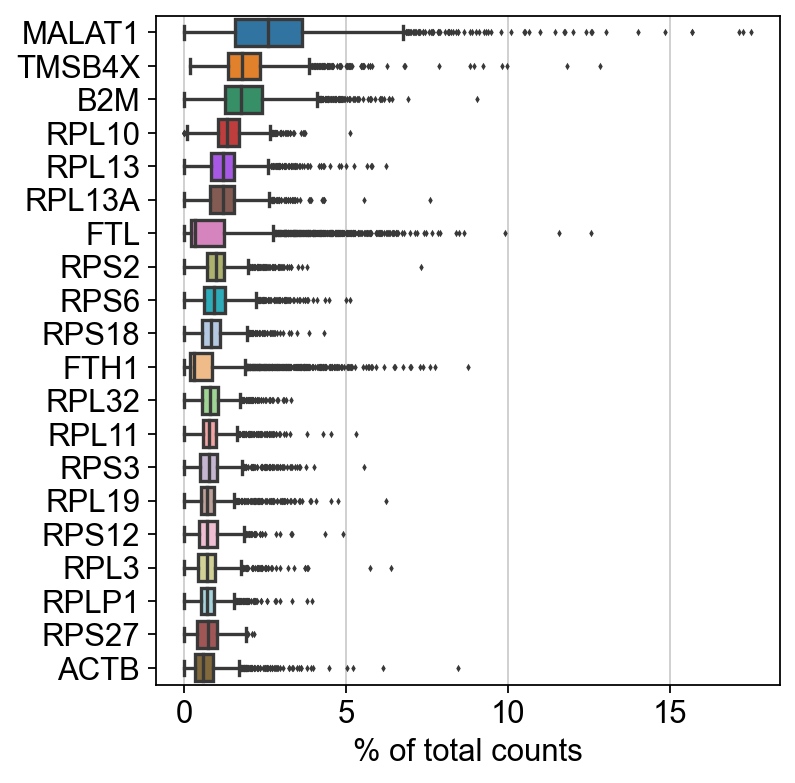

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

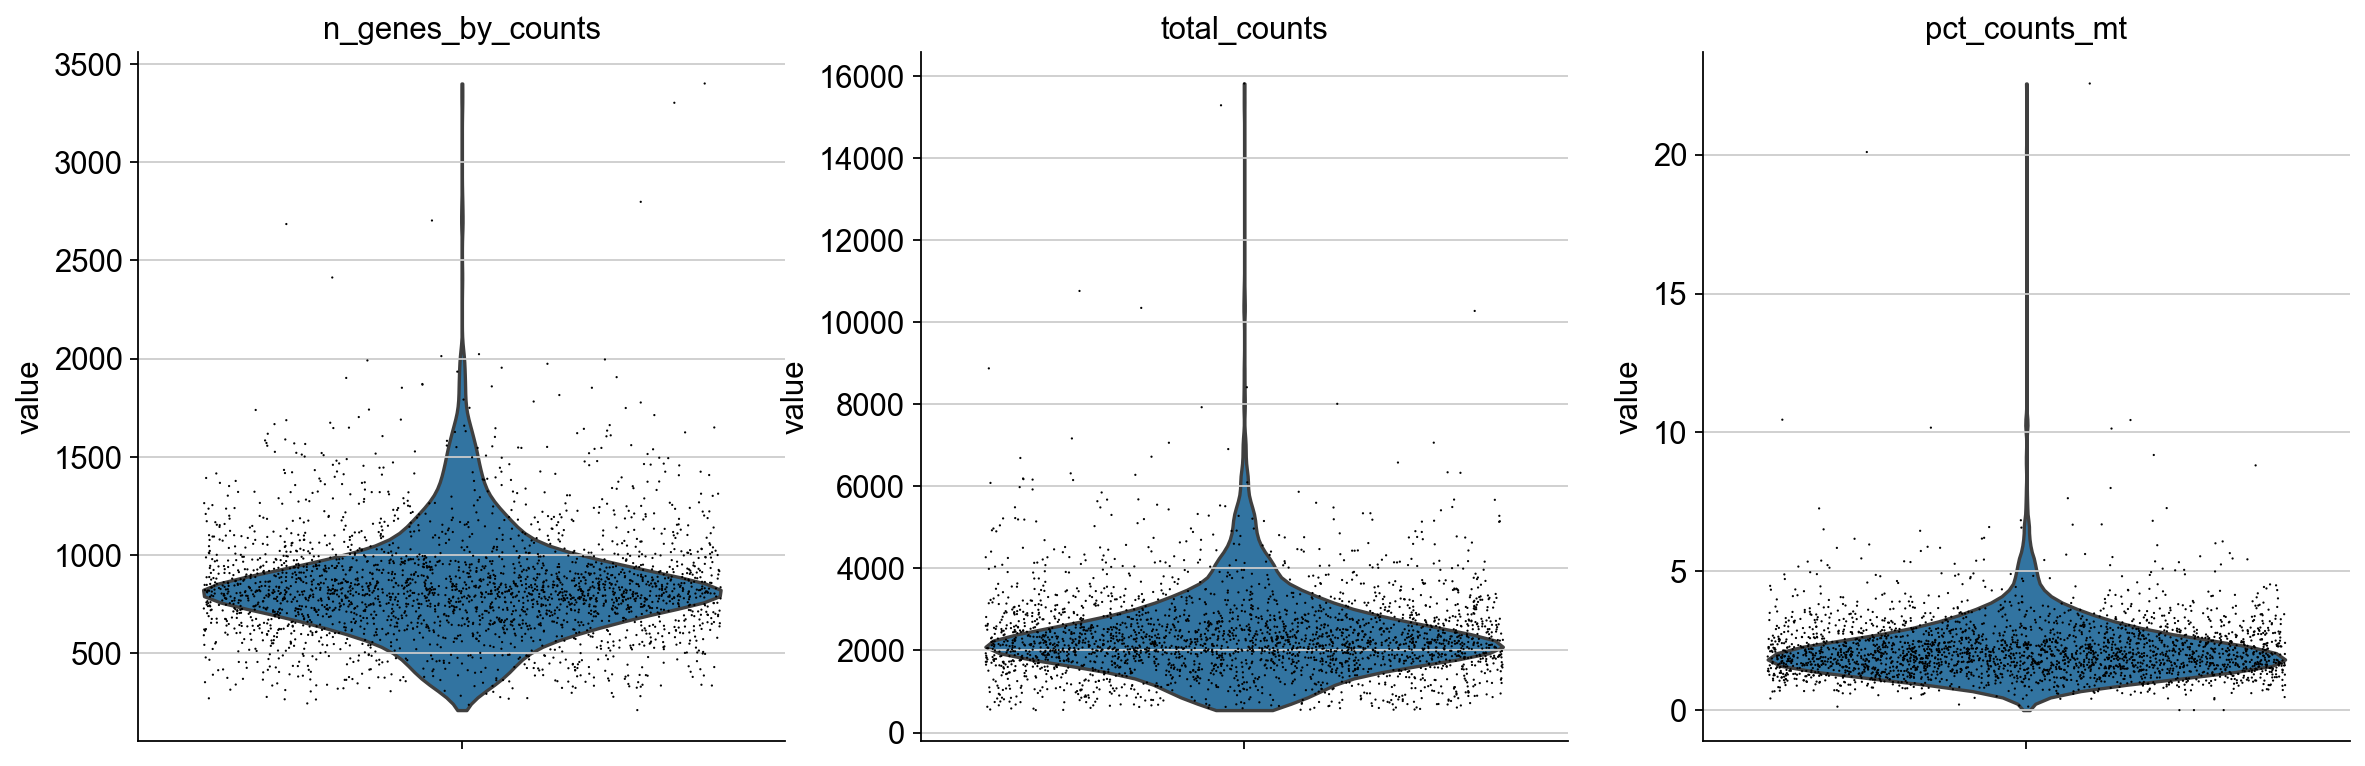

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

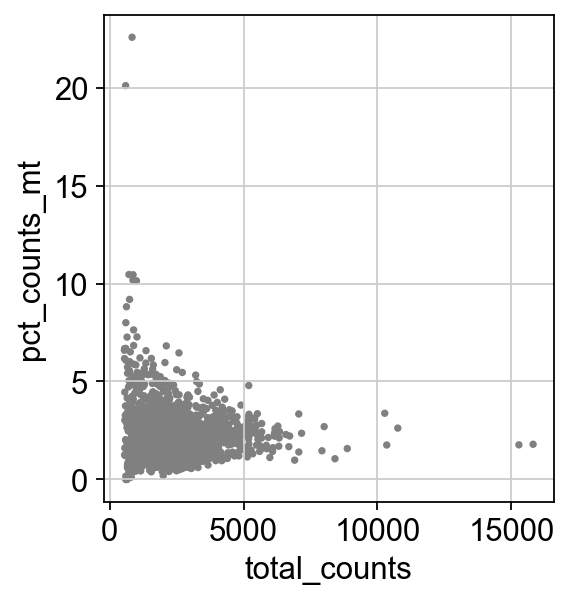

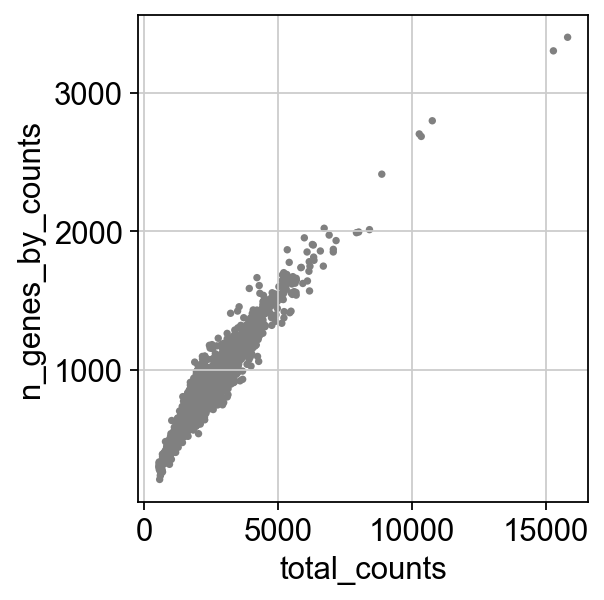

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


C:\Users\vekat\anaconda\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Пакетные эффекты

Для устранения пакетных эффектов при совместном использовании нескольких наборов данных обычно применяют методы **pp.combat(adata[, key, covariates, inplace])** и **pp.mnn_correct(*data[, var_index, ...])**.

![batch](figures/batch.png)

## Определение высоковариабельных генов и уменьшение количества транскриптов

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


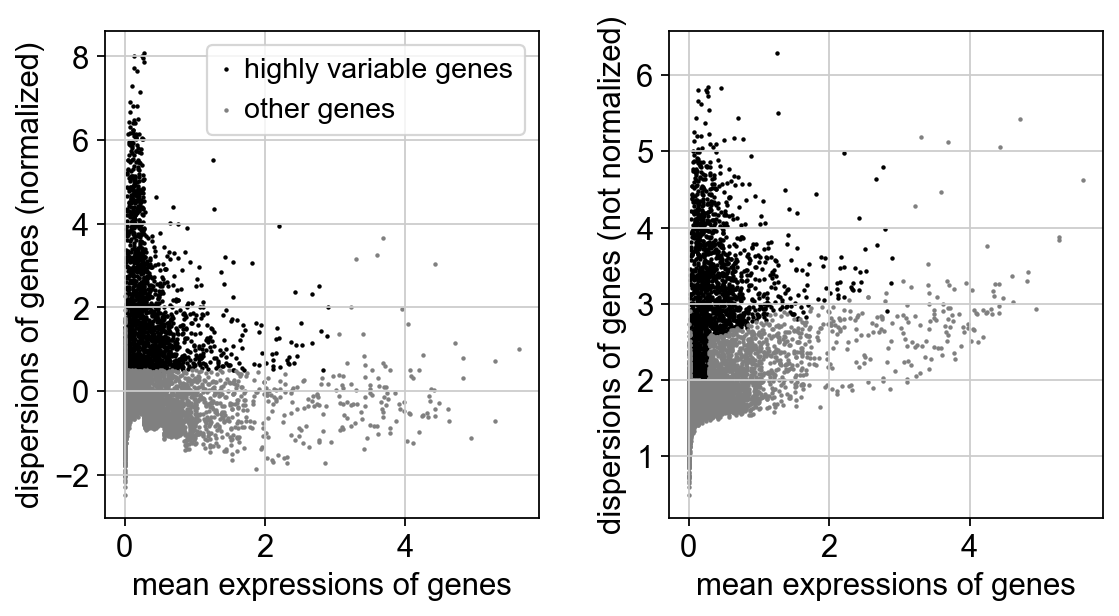

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [18]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


In [19]:
sc.pp.scale(adata, max_value=10)

## Анализ основных компонент (PCA)

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


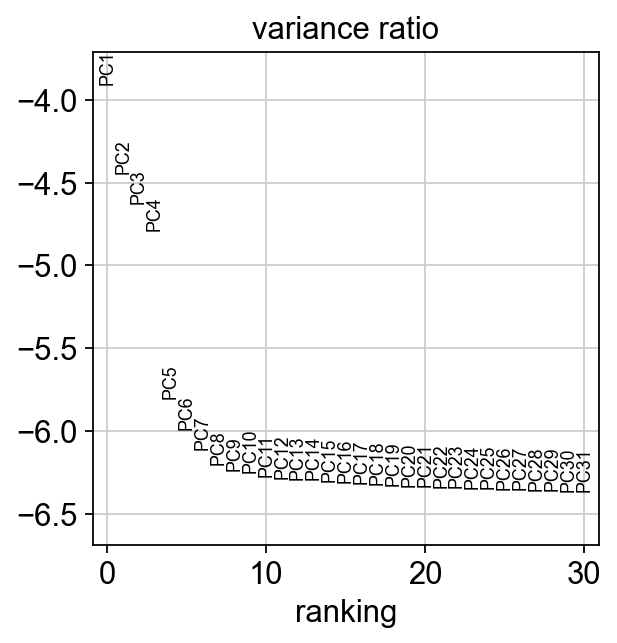

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'